In [1]:
##### IMPORT LIBRARIES

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew
from scipy.special import boxcox1p
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("housepricestrain.csv")
test = pd.read_csv("housepricestest.csv")

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
trainshape = ("Train Data:",train.shape[0],"obs, and", train.shape[1], "features" )
print("\033[95m {}\033[00m" .format(trainshape))
testshape = ("Test Data:",test.shape[0],"obs, and", test.shape[1], "features" )
print("\033[95m {}\033[00m" .format(testshape))

 ('Train Data:', 1460, 'obs, and', 81, 'features')
 ('Test Data:', 1459, 'obs, and', 80, 'features')


In [6]:
# save id 
train_id = train["Id"]
test_id = test["Id"]

# drop id
train.drop("Id" , axis = 1 , inplace = True)
test.drop("Id" , axis = 1 , inplace = True)

In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0


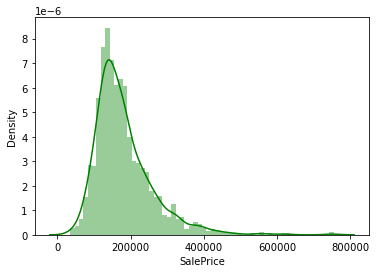

In [8]:
# Focus Target Variable

sns.distplot(train["SalePrice"] , color = "g", bins = 60 , hist_kws={"alpha": 0.4});

In [9]:
#As we can see at the above, the target variable SalePrice is not distributed normally.
#This can reduce the performance of the ML regression models because some of them assume normal distribution.
#Therfore we need to log transform.

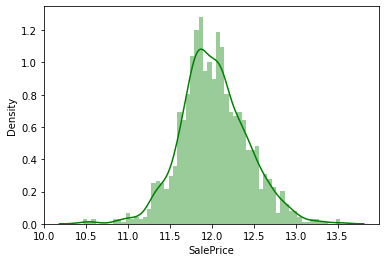

In [10]:
sns.distplot(np.log1p(train["SalePrice"]) , color = "g", bins = 60 , hist_kws={"alpha": 0.4});

In [11]:
# Focus Correlations

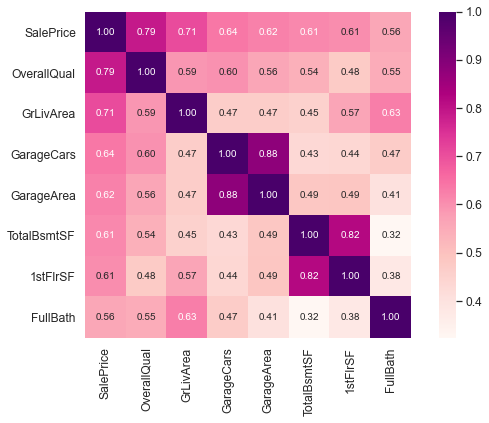

In [12]:
corrmatrix = train.corr()
plt.figure(figsize = (10,6))
columnss = corrmatrix.nlargest(8, "SalePrice")["SalePrice"].index
cm = np.corrcoef(train[columnss].values.T)
sns.set(font_scale = 1.1)
hm = sns.heatmap(cm, cbar = True, annot = True, square = True, cmap = "RdPu" ,  fmt = ".2f", annot_kws = {"size": 10},
                 yticklabels = columnss.values, xticklabels = columnss.values)
plt.show()

In [13]:
# let's look at the distribution of the variable with the 3 highest correlations

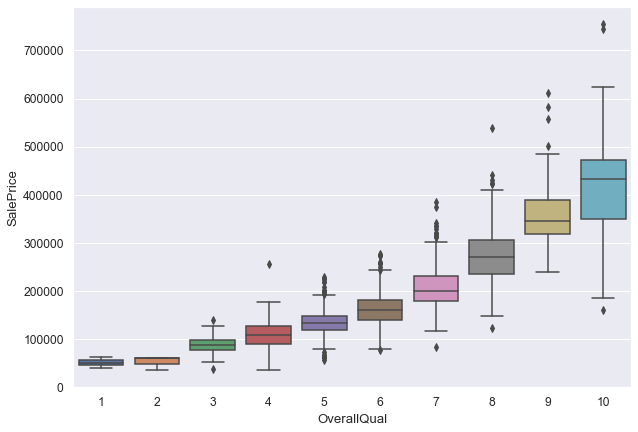

In [14]:
f, ax = plt.subplots(figsize = (10, 7))
sns.boxplot(x = "OverallQual", y = "SalePrice", data = train);

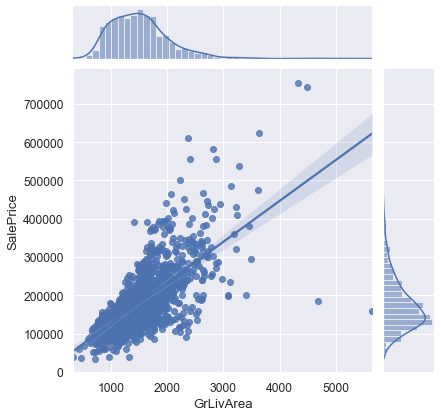

In [15]:
sns.jointplot(x = train["GrLivArea"], y = train["SalePrice"], kind = "reg");

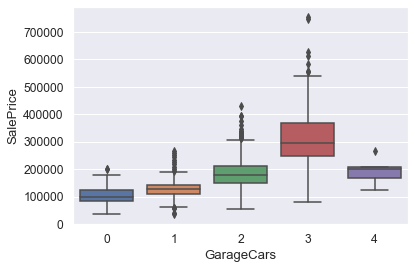

In [16]:
sns.boxplot(x = train["GarageCars"], y = train["SalePrice"]);

In [17]:
#OUTLIERS
#Can you see two points at the bottom right on GrLivArea. Yes ! It's outliers !
#Car garages result in less Sale Price? That doesn't make much sense.
#We need to remove outliers.

In [18]:
train = train.drop(train[(train["GrLivArea"] > 4000) 
                         & (train["SalePrice"] < 200000)].index).reset_index(drop = True)
train = train.drop(train[(train["GarageCars"] > 3) 
                         & (train["SalePrice"] < 300000)].index).reset_index(drop = True)

In [19]:
#It should look better.

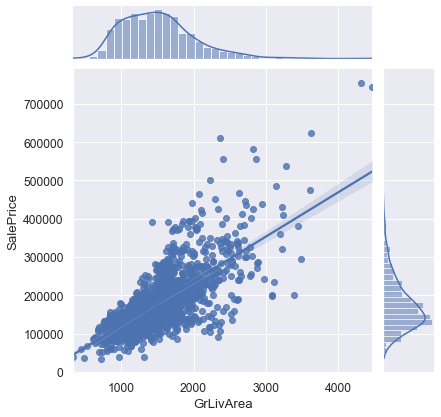

In [20]:
sns.jointplot(x = train["GrLivArea"], y = train["SalePrice"], kind = "reg");

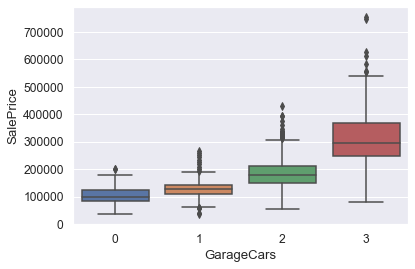

In [21]:
sns.boxplot(x = train["GarageCars"], y = train["SalePrice"]);

In [22]:
#They Look succesfull.
#Now, we need to concanete train and test data for some cleaning operations.

In [23]:
df = pd.concat((train, test)).reset_index(drop = True)
df.drop(["SalePrice"], axis = 1, inplace = True)
df.shape

(2912, 79)

In [24]:
##Focus missing values

df.isna().sum().nlargest(35)

PoolQC          2903
MiscFeature     2807
Alley           2715
Fence           2342
FireplaceQu     1417
LotFrontage      485
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageCond       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
Utilities          2
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Exterior1st        1
Exterior2nd        1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
KitchenQual        1
GarageCars         1
GarageArea         1
SaleType           1
MSSubClass         0
dtype: int64

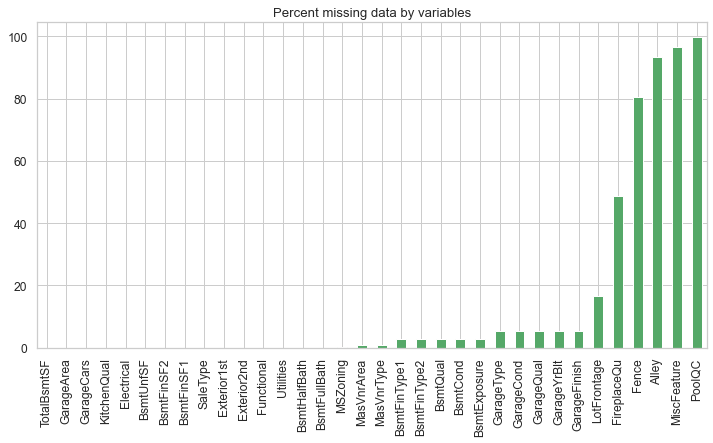

In [25]:
#As can be seen, there are many missing observations in the data.
sns.set_style("whitegrid")
f , ax = plt.subplots(figsize = (12, 6))
miss = round(df.isnull().mean()*100,2)
miss = miss[miss > 0]
miss.sort_values(inplace = True)
miss.plot.bar(color = "g")
ax.set(title="Percent missing data by variables");

In [26]:
#MISSING VALUES !
#For a few columns there is lots of NaN entries.
#However, reading the data description we find this is not missing data:
#For PoolQC, NaN is not missing data but means no pool, likewise for Fence, FireplaceQu etc.
#Now, lets filling NA values :)

In [27]:
some_miss_columns = ["PoolQC","MiscFeature","Alley","Fence","FireplaceQu","GarageType","GarageFinish","GarageQual","GarageCond",
                  "BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","MasVnrType","MSSubClass"]

for i in some_miss_columns :
        df[i].fillna("None" , inplace = True)

In [28]:
df["Functional"] = df["Functional"].fillna("Typ")

In [29]:
some_miss_columns2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities","MSZoning",
                      "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd","MasVnrArea"]
for i in some_miss_columns2:
    df[i].fillna(df[i].mode()[0], inplace = True)

In [30]:
some_miss_columns3 = ["GarageYrBlt", "GarageArea", "GarageCars","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF"]
for i in some_miss_columns3 :
    df[i] = df[i].fillna(0)

In [31]:
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [32]:
#We've filled out all the missing data.
#Let's control.

In [33]:
df.isna().sum().nlargest(3)

MSSubClass     0
MSZoning       0
LotFrontage    0
dtype: int64

In [34]:
#We need transformation for some features.
Nm = ["MSSubClass","MoSold","YrSold"]
for col in Nm:
    df[col] = df[col].astype(str)

In [35]:
#Label Encoder
#Convert this kind of categorical text data into model-understandable numerical data, we use the Label Encoder class.

In [36]:
lbe = LabelEncoder()
encodecolumns = ("FireplaceQu","BsmtQual","BsmtCond","ExterQual","ExterCond","HeatingQC","GarageQual",
                "GarageCond","PoolQC","KitchenQual","BsmtFinType1","BsmtFinType2","Functional","Fence",
                "BsmtExposure","GarageFinish","LandSlope","LotShape","PavedDrive","Street","Alley",
                "CentralAir","MSSubClass","OverallCond","YrSold","MoSold")
for i in encodecolumns :
    lbe.fit(list(df[i].values))
    df[i] = lbe.transform(list(df[i].values))

In [37]:
#Log Transform for SalePrice
#We must apply logarithmic transformation to our target variable.Because ML models work better with normal distribution.

In [38]:
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train.SalePrice.values
y[:5]

array([12.24769912, 12.10901644, 12.31717117, 11.84940484, 12.4292202 ])

In [39]:
#Fixing "Skewed" features
#We need to fix all of the skewed data to be more normal so that our models will be more accurate when making predictions.

In [40]:
numeric = df.dtypes[df.dtypes != "object"].index
skewed_var = df[numeric].apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
skewness = pd.DataFrame({"Skewed Features" :skewed_var})
skewness.head()

,Skewed Features
MiscVal,21.920854
PoolArea,17.673354
LotArea,13.150188
LowQualFinSF,12.073977
3SsnPorch,11.362112


In [41]:
#Now we will apply box cox transformation to these skewed values. So what is box cox transformation?

In [42]:
#Box Cox Transformation
#A Box Cox transformation is a transformation of a non-normal dependent variables into a normal shape. Normality is an important assumption for many statistical techniques; if your data isn’t normal, applying a Box-Cox means that you are able to run a broader number of tests.
#References : Box, G. E. P. and Cox, D. R. (1964). An analysis of transformations.
#Lets do it.

In [43]:
skewness = skewness[abs(skewness) > 0.75]
skewed_var2 = skewness.index
for i in skewed_var2:
    df[i] = boxcox1p(df[i], 0.15)
    df[i] += 1

In [44]:
#Dummy Variables
#Next step is dummy variables !
#In statistics and econometrics, particularly in regression analysis, a dummy variable is one that takes only the value 0 or 1 to indicate the absence or presence of some categorical effect that may be expected to shift the outcome.

In [45]:
df = pd.get_dummies(df)
df.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,3.885846,6.831328,20.212182,1.730463,1.730463,2.540963,1.0,3.440268,2.820334,15.187527,...,0,0,0,1,0,0,0,0,1,0
1,3.055642,7.221214,20.712205,1.730463,1.730463,2.540963,1.0,3.259674,3.440268,15.145138,...,0,0,0,1,0,0,0,0,1,0
2,3.885846,6.914940,21.347241,1.730463,1.730463,1.000000,1.0,3.440268,2.820334,15.184404,...,0,0,0,1,0,0,0,0,1,0
3,4.011340,6.684507,20.691553,1.730463,1.730463,1.000000,1.0,3.440268,2.820334,15.047529,...,0,0,0,1,1,0,0,0,0,0
4,3.885846,7.314735,22.325160,1.730463,1.730463,1.000000,1.0,3.602594,2.820334,15.182841,...,0,0,0,1,0,0,0,0,1,0


In [46]:
X_train = df[:train.shape[0]]
X_test = df[train.shape[0]:]

In [47]:
#Now, we are ready to ML but i want to try PCA. So what is the PCA ?

In [48]:
#PCA (Principal component analysis)
#PCA is used in exploratory data analysis and for making predictive models. 
#It is commonly used for dimensionality reduction by projecting each data point onto only the first few principal components to obtain lower-dimensional data while preserving as much of the data's variation as possible. 
#The first principal component can equivalently be defined as a direction that maximizes the variance of the projected data. Lets try it.
#Note : You need to standardize the data before using PCA.

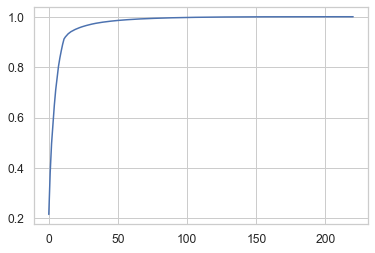

In [49]:
dff = df.copy()
##df_standardize = StandardScaler().fit_transform(dff)
##I didn't standardize it again because the data is already close to the standard.
pca = PCA()
pca_fit = pca.fit_transform(dff)
pca = PCA().fit(dff)
plt.plot(np.cumsum(pca.explained_variance_ratio_));

In [50]:
#With about 30 variables, we can explain 90% of the variance in the dataset.How do we do that ?

In [51]:
pca = PCA(n_components = 30)
pca_fit = pca.fit_transform(dff)
pca_df = pd.DataFrame(data = pca_fit)
pca_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.310874,-7.644388,-3.190557,-6.130242,-1.231003,1.802676,0.149904,1.802519,-0.081996,-1.064012,...,0.016373,0.699636,-0.548163,0.058137,0.336915,-0.305455,-0.277113,0.110743,0.145070,-0.164912
1,-6.792759,0.934007,-1.220512,5.201498,1.143536,-3.922942,-3.233540,0.318292,-1.110764,-0.084848,...,0.258797,0.456173,0.093516,-0.358056,0.546870,1.350951,-0.319384,0.242811,-0.699054,0.953552
2,2.258800,-7.309320,-1.561536,-5.963476,-1.504997,0.673385,-0.047281,0.567739,-0.445352,-0.352704,...,-0.049261,0.249149,0.112560,0.159644,0.590755,-0.634819,-0.290203,-0.274488,0.168881,-0.229863
3,5.713698,-1.996913,-4.386689,-2.343667,-4.081766,-3.358525,-0.259982,-2.570543,6.024252,-1.719936,...,0.139250,-1.481852,0.613636,-0.325457,0.893195,0.797417,1.100594,0.184938,-0.442845,-0.462311
4,0.639671,-12.038284,0.643347,-0.953167,2.368347,0.493921,-0.421904,0.242407,0.724364,-0.126743,...,-0.268913,-0.100734,0.316328,0.417055,0.931037,-0.269311,-0.157023,0.121939,0.236291,0.376328


In [52]:
#Now, we will predict models ! Firstly start Cross-validation with k-folds

n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle = True, random_state = 42).get_n_splits(X_train.values)
    rmse = np.sqrt(-cross_val_score(model, X_train.values, y, scoring = "neg_mean_squared_error", cv = kf))
    return(rmse)

In [53]:
model_xgb = xgb.XGBRegressor(colsample_bytree = 0.2, gamma = 0.0 ,
                             learning_rate = 0.05, max_depth = 6, 
                             min_child_weight = 1.5, n_estimators = 7200,
                             reg_alpha = 0.9, reg_lambda = 0.6,
                             subsample = 0.2,seed = 42,
                             random_state = 7)

model_gbm = GradientBoostingRegressor(n_estimators = 3000, learning_rate = 0.05,
                                   max_depth = 4, max_features = "sqrt",
                                   min_samples_leaf = 15, min_samples_split = 10, 
                                   loss = "huber", random_state = 5)

In [54]:
#Checking performance of base models by evaluating the cross-validation RMSLE error.

score = rmsle_cv(model_xgb)
print("XGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_gbm)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

XGBoost score: 0.1203 (0.0059)

Gradient Boosting score: 0.1155 (0.0067)



In [55]:
## we need this func

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [56]:
## XGBOOST

model_xgb.fit(X_train, y)
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = np.expm1(model_xgb.predict(X_test))
print(rmsle(y, xgb_train_pred))

0.04260613199952808


In [57]:
xgb_pred[:5]

array([124474.59, 156253.73, 183685.36, 187832.9 , 190163.44],
      dtype=float32)

In [58]:
## Gradient Boosting Machines

model_gbm.fit(X_train, y)
gbm_train_pred = model_gbm.predict(X_train)
gbm_pred = np.expm1(model_gbm.predict(X_test.values))
print(rmsle(y, gbm_train_pred))

0.05041437359684844


In [59]:
gbm_pred[:5]

array([120735.81992324, 156981.67681747, 194467.06024408, 196102.90381639,
       189486.60416949])

In [60]:
final_pred = (0.5 * xgb_pred) + (0.5 * gbm_pred)

In [61]:
submission = pd.DataFrame({"Id": test_id, "SalePrice": final_pred})
submission.head(5)

,Id,SalePrice
0,1461,122605.206837
1,1462,156617.705596
2,1463,189076.209810
3,1464,191967.905033
4,1465,189825.020835


In [62]:
submission.to_csv("submission.csv", index = False)